# Modellierung der zu erwartenden Schadenshöhe pro Versicherungsnehmer und Jahr

## Aufgabenstellung
Unter https://www.openml.org/d/41214 und https://www.openml.org/d/41215 finden Sie zwei Datensätze eines französischen Automobilversicherers. Diese beinhalten Risikomerkmale und Schaden- informationen zu Kraftfahrt-Haftpflicht-Versicherungsverträgen (eine Datensatzbeschreibung finden Sie am Ende dieses Textes). Ihre Aufgabe besteht in der Modellierung der zu erwartenden Schadenhöhe pro Versicherungsnehmer und Jahr anhand der Risikomerkmale der Kunden. Dieser Wert ist Basis für die Berechnung eines fairen Versicherungsbeitrags.

## Datensatzbeschreibung 
freMTPL2freq:
- IDpol: ID des Vertrags
- ClaimNb: Anzahl Schäden im Versicherungszeitraum
- Exposure: Länge des Versicherungszeitraums (in Jahren) [Komponente der abhängigen
Variable]
- Area: Area-Code des Versicherungsnehmers [unabhängige Variable]
- VehPower: Leistung des versicherten Kfz [unabhängige Variable]
- VehAge: Alter des versicherten Kfz [unabhängige Variable]
- DrivAge: Alter des Versicherungsnehmers [unabhängige Variable]
- BonusMalus: Schadenfreiheitsrabatt (französische Entsprechung der Schadenfreiheitsklasse)
[unabhängige Variable]
- VehBrand: Marke des versicherten Kfz [unabhängige Variable]
- VehGas: Antrieb des versicherten Kfz [unabhängige Variable]
- Density: Anzahl der Einwohner pro km2 im Wohnort des Versicherungsnehmers [unabhängige Variable]
- Region: Region des Versicherungsnehmers [unabhängige Variable]

freMTPL2sev:
- IDpol: ID des Vertrags
- ClaimAmount: Höhe der einzelnen Schadenaufwände (mehrere Einträge pro Vertrag, falls im
Zeitraum mehrere Schäden vorhanden waren.) [Komponente der abhängigen Variable.]

Die abhängige Variable ist definiert als ClaimAmount / Exposure.

## Import der genutzen Pakete

In [1]:
import arff
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from IPython.display import Markdown
from math import sqrt

## Datenimport und grundlegendes Cleaning

In [2]:
data_freq = arff.load('data/freMTPL2freq.arff')
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower",
"VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])
data_sev = arff.load('data/freMTPL2sev.arff')
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])

In [3]:
# Überblick über die beiden Dataframes gewinnen
display(Markdown('**Überblick über df_freq**'))
print(df_freq.info())
display(df_freq.head(2))

display(Markdown('**Überblick über df_sev**'))
print(df_sev.info())
display(df_sev.head(2))


**Überblick über df_freq**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  float64
 1   ClaimNb     678013 non-null  float64
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  float64
 5   VehAge      678013 non-null  float64
 6   DrivAge     678013 non-null  float64
 7   BonusMalus  678013 non-null  float64
 8   VehBrand    678013 non-null  object 
 9   VehGas      678013 non-null  object 
 10  Density     678013 non-null  float64
 11  Region      678013 non-null  object 
dtypes: float64(8), object(4)
memory usage: 62.1+ MB
None


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
1,3.0,1.0,0.77,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'


**Überblick über df_sev**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26639 entries, 0 to 26638
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   IDpol        26639 non-null  float64
 1   ClaimAmount  26639 non-null  float64
dtypes: float64(2)
memory usage: 416.4 KB
None


,IDpol,ClaimAmount
0,1552.0,995.20
1,1010996.0,1128.12


#### Beobachtungen: 
- colnames beinhalten Großbuchstaben, was zu unnötigen Tippfehlern im späteren Verlauf führen kann -> Konvertierung in lowercase 
- IDPol ist float, obwohl es sich um eine ganze Zahl handelt -> Konvertierung in int, um Missmatches beim mergen vozubeugen (Stichwort: Ungenauigkeit der Binärdarstellung von floats)
- Die Werte der kategorialen Variablen area, VehGas und Region enthalten zusätzliche '', die entfernt werden sollten
- Konvertiere kategoriale Variables as categorial, das erleichtert später die One-Hot-Kodierung
- Die beiden Ursprungstabellen enthalten keine NAs, daher ist an dieser Stelle keine weitere Analyse notwendig

In [4]:
# Konvertierung der colnames in lowercase
df_freq.columns = df_freq.columns.str.lower()
df_sev.columns = df_sev.columns.str.lower()

# Check, ob die Annahme, dass es sich bei den Ids um ints handelt stichhaltig ist:
print("Anzahl der Ids in df_freq, die mehr als E-9 Abstand zu einer ganzen Zahl haben: ", (abs(df_freq.idpol % 1) > 0.000000001).sum())
print("Anzahl der Ids in df_sev, die mehr als E-9 Abstand zu einer ganzen Zahl haben: ", (abs(df_sev.idpol % 1) > 0.000000001).sum())

Anzahl der Ids in df_freq, die mehr als E-9 Abstand zu einer ganzen Zahl haben:  0
Anzahl der Ids in df_sev, die mehr als E-9 Abstand zu einer ganzen Zahl haben:  0


In [5]:
# Ausweitung der Checks auf die Columns ["idpol", "claimnb", "vehpower", "vehage", "drivage", "bonusmalus", "density"]
print("Anzahl der Werte in df_freq in den relevanten columns, die mehr als E-9 Abstand zu einer ganzen Zahl haben:")
(abs(df_freq[["idpol", "claimnb", "vehpower", "vehage", "drivage", "bonusmalus", "density"]]%1) >0.000000001).sum()

Anzahl der Werte in df_freq in den relevanten columns, die mehr als E-9 Abstand zu einer ganzen Zahl haben:


idpol         0
claimnb       0
vehpower      0
vehage        0
drivage       0
bonusmalus    0
density       0
dtype: int64

In [6]:
# Umwandlung der Spalten ["idpol", "claimnb", "vehpower", "vehage", "drivage", "bonusmalus", "density"] in df_freq in int
for col in ["idpol", "claimnb", "vehpower", "vehage", "drivage", "bonusmalus", "density"]:
    df_freq[col] = df_freq[col].astype(int)

# Umwandlung von idpol in df_sev in int
df_sev.idpol = df_sev.idpol.astype(int)

In [7]:
# Überprüfe, ob die Spalten ["area","vehbrand","region"] wie vermutet in allen Werten zusätzliche '' haben
 
for col in ["area","vehbrand","region"]:
    print("Variable", col, "hat die Werte", df_freq[col].unique())

Variable area hat die Werte ["'D'" "'B'" "'E'" "'C'" "'F'" "'A'"]
Variable vehbrand hat die Werte ["'B12'" "'B6'" "'B3'" "'B2'" "'B5'" "'B10'" "'B14'" "'B13'" "'B4'" "'B1'"
 "'B11'"]
Variable region hat die Werte ["'R82'" "'R22'" "'R72'" "'R31'" "'R91'" "'R52'" "'R93'" "'R11'" "'R24'"
 "'R94'" "'R83'" "'R54'" "'R26'" "'R53'" "'R73'" "'R42'" "'R25'" "'R21'"
 "'R41'" "'R43'" "'R74'" "'R23'"]


In [8]:
# Wie vermutet beinhalten alle Werte der Spalten ["area","vehbrand","region"] zusätzliche'', die im folgenden entfernt werden:
for col in ["area","vehbrand","region"]:
    df_freq[col] = df_freq[col].str.replace("'", "")

# Check, ob die Transformation erfolgreich war:
for col in ["area","vehbrand","region"]:
    print("Variable", col, "hat die Werte", df_freq[col].unique())

Variable area hat die Werte ['D' 'B' 'E' 'C' 'F' 'A']
Variable vehbrand hat die Werte ['B12' 'B6' 'B3' 'B2' 'B5' 'B10' 'B14' 'B13' 'B4' 'B1' 'B11']
Variable region hat die Werte ['R82' 'R22' 'R72' 'R31' 'R91' 'R52' 'R93' 'R11' 'R24' 'R94' 'R83' 'R54'
 'R26' 'R53' 'R73' 'R42' 'R25' 'R21' 'R41' 'R43' 'R74' 'R23']


In [9]:
# Überblick über die Werte in ["area","vehbrand","region"]:
for col in ["area","vehbrand","region", "vehgas"]:
    df_freq[col] = df_freq[col].astype("category")

print("Übersicht über die bereinigten Datentypen bei df_freq:")
df_freq.dtypes

Übersicht über die bereinigten Datentypen bei df_freq:


idpol            int64
claimnb          int64
exposure       float64
area          category
vehpower         int64
vehage           int64
drivage          int64
bonusmalus       int64
vehbrand      category
vehgas        category
density          int64
region        category
dtype: object

### Zusammenführen der DataFrames df_freq und df_sev

- idpol ist der Schlüssel, der in beiden Tabellen enthalten ist und über den der Merge ausgeführt wird
- Bisher ist noch nicht klar, in wie weit die ids in den Tabellen matchen. Dies wird zuerst analysiert.
- Aus der Datensatzbeschreibung ist ersichtlich, dass dev_sev pro Schaden eine Zeile enthält. Daher sollten die Variable claimnb in df_freq und die Anzahl der zugehörigen Rows zu einem Vertrag in df_sev übereinstimmen

In [10]:
# Zähle die ANzahl der Zeilen pro idpol in df_sev und merge df_freq per left-join. Danach zeige, welche idpols der oben beschriebenen Logik widersprechen:
pd.DataFrame(df_sev.idpol.value_counts()).merge(df_freq[["idpol", "claimnb"]], on="idpol", how="left").query("claimnb != count")

,idpol,count,claimnb
0,2262511,66,NaN
1,2282134,36,NaN
2,2227533,25,NaN
3,2220367,24,NaN
4,2277846,23,NaN
5,2286775,21,NaN
11500,4158255,1,2.0


#### Beobachtung:
- es gibt 6 idpols in df_dev, wo es keinen Match in df_freq gibt
   - ohne Zuordnung von covariates kann ein Modell, was direkt den erwarteten Schaden pro Jahr predicted nichts mit diesen Zeilen anfangen -> Enscheidung: drop der Zeilen
- eine Zeile hat claimnb = 2 > 1 = ANzahl Schadensfälle in df_sev -> da es nur eine Zeile ist, wird dieser Datenfehler ignoriert.

In [11]:
# Kopiere df_sev, falls das Original später noch gebraucht wird:
df_sev_orig = df_sev.copy()

# drop der Zeilen mit idpol [2262511, 2282134, 2227533, 2220367, 2277846, 2286775]
df_sev = df_sev.loc[~df_sev.idpol.isin([2262511, 2282134, 2227533, 2220367, 2277846, 2286775]),:]
# Gedanke: wäre auch später über left-join möglich gewesen


In [12]:
#  Zähle die Anzahl der Zeilen pro idpol in df_sev und merge df_freq per right-join. Danach zeige, welche idpols der oben beschriebenen Logik widersprechen:

display(pd.DataFrame(df_sev.idpol.value_counts()).merge(df_freq[["idpol", "claimnb"]], on="idpol", how="right").query("claimnb >0 & count.isna()"))

claim_num_no_match =  pd.DataFrame(df_sev.idpol.value_counts()).merge(df_freq[["idpol", "claimnb"]], on="idpol", how="right").query("claimnb >0 & count.isna()").claimnb.sum()
print("Für insgesamt ",claim_num_no_match, " Fälle sind keine Schadenshöhen vorhanden!")
print("In df_freq sind ", df_freq.claimnb.sum(), "Schäden gezählt.")
ratio_no_claim_height_total_claims = claim_num_no_match/df_freq.claimnb.sum()
print("Für", (ratio_no_claim_height_total_claims*100).round(2), "% der Schadensfälle sind keine Schadenshöhe vorhanden")


,idpol,count,claimnb
0,1,NaN,1
1,3,NaN,1
2,5,NaN,1
3,10,NaN,1
4,11,NaN,1
...,...,...,...
533623,4124801,NaN,1
535346,4126524,NaN,1
545407,4136585,NaN,1
595288,4186466,NaN,1


Für insgesamt  9657  Fälle sind keine Schadenshöhen vorhanden!
In df_freq sind  36102 Schäden gezählt.
Für 26.75 % der Schadensfälle sind keine Schadenshöhe vorhanden


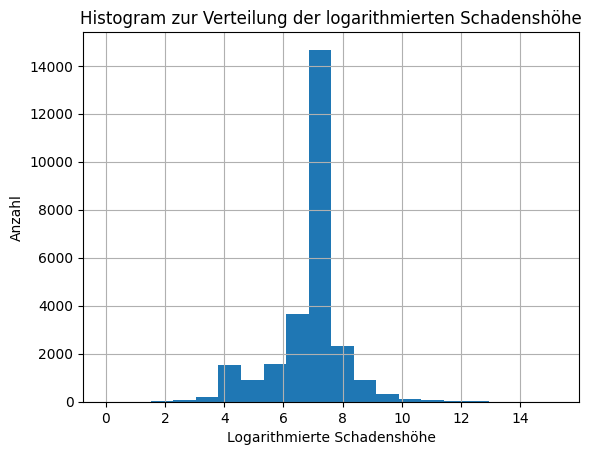

In [13]:
# Plotte Verteilung der Schadenshöhe, um eine Imputation beurteilen zu können:
np.log(df_sev.claimamount).hist(bins= 20)
plt.xlabel("Logarithmierte Schadenshöhe")
plt.ylabel("Anzahl")
plt.title("Histogram zur Verteilung der logarithmierten Schadenshöhe");

#### Beobachtung: 
- ca. 1/4 der Schadensfälle hat keine Informationen zur SChadenshöhe
- Schwierige Entscheidung, wie weiter zu verfahren ist, Möglichkeiten:
   - Schadenshöhe imputieren für fehlende Werte
      - Verteilung deutlich rechtsschief und vermutlich abhängig von Risikomerkmalen -> keine einfache Imputation mit z.B. Mittelwert sinnvoll
      - Komplexere Imputation mit ML-Verfahren möglich, aber sprengt den zeitlichen Rahmen
      - Gefahr von Leakage bei der späteren Modellbeurteilung
   - Alle mismatches entfernen
      - Erhebliches Informationsverlust
      - Führt zu starken Bias im Datensatz, den späteres Modell lernt
   - Alle mismatches entfernen und zufällig 27% der Daten in df_freq entfernen, die keinen Unfall beinhalten
      - Größter Informationsverlust
      - Verhinderung von Bias im Datensatz 
- Entscheidung: Option 3 

In [14]:
idpols_to_remove = list(pd.DataFrame(df_sev.idpol.value_counts()).merge(df_freq[["idpol", "claimnb"]], on="idpol", how="right").query("claimnb >0 & count.isna()").idpol)

# Kopiere df_freq, falls Original später noch einmal benötigt wird
df_freq_orig = df_freq.copy()


In [15]:
# entferne idpols
df_freq = df_freq.loc[~df_freq.idpol.isin(idpols_to_remove),:]
print(df_freq.shape)


(668897, 12)


In [16]:
df_freq_with_claims = df_freq.query("claimnb > 0")
df_freq_without_claims = df_freq.query("claimnb == 0")
print(df_freq_with_claims.shape, df_freq_without_claims.shape)

(24944, 12) (643953, 12)


In [17]:
df_freq_without_claims_sample = df_freq_without_claims.sample(frac=1-ratio_no_claim_height_total_claims,replace=False, random_state=4)
print(df_freq_without_claims_sample.shape[0]/df_freq_without_claims.shape[0])

0.732508428410148


In [18]:
# Setze das angepasste df_freq wieder zusammen
df_freq_sample = pd.concat([df_freq_without_claims_sample,df_freq_with_claims])
df_freq_sample.head(3)

,idpol,claimnb,exposure,area,vehpower,vehage,drivage,bonusmalus,vehbrand,vehgas,density,region
136655,1097896,0,0.57,C,5,11,42,85,B5,Regular,192,R24
342864,2276010,0,0.50,A,7,1,40,51,B4,Diesel,44,R93
332941,2266087,0,0.08,D,5,10,35,51,B4,Diesel,1448,R93


In [19]:
# Aggregiere df_sev nach idpol, da später nur die aggregierte Schadenshöhe pro Vertrag benötigt wird
df_sev = df_sev.groupby("idpol").sum().reset_index()
# überprüfe, dass keine jede ID nur noch einmal vorkommt
df_sev.idpol.value_counts()

idpol
139        1
3098141    1
3099495    1
3099439    1
3099378    1
          ..
1155513    1
1155460    1
1155433    1
1155380    1
6113971    1
Name: count, Length: 24944, dtype: int64

In [20]:
# merge df_freq_sample und df_sev

df = df_freq_sample.merge(df_sev, on="idpol", how="left")

print("Überprüfe, ob es NAs gibt:")
df.isna().sum()

Überprüfe, ob es NAs gibt:


idpol               0
claimnb             0
exposure            0
area                0
vehpower            0
vehage              0
drivage             0
bonusmalus          0
vehbrand            0
vehgas              0
density             0
region              0
claimamount    471701
dtype: int64

In [21]:
# Check, ob es außer den Zeilen, wo es keine Schadensfälle gab, noch andere NAs gibt (was nicht sein sollte)
df.query("claimamount.isna() & claimnb>0")

,idpol,claimnb,exposure,area,vehpower,vehage,drivage,bonusmalus,vehbrand,vehgas,density,region,claimamount


In [22]:
# fülle Nas mit 0, da der Test erfolgreich war
df.claimamount = df.claimamount.fillna(0)

In [23]:
# Generiere Zielvariable
df["claimamount_by_exp"] = df.claimamount/df.exposure

## EDA

In [24]:
display(df.head(), df.describe())

,idpol,claimnb,exposure,area,vehpower,vehage,drivage,bonusmalus,vehbrand,vehgas,density,region,claimamount,claimamount_by_exp
0,1097896,0,0.57,C,5,11,42,85,B5,Regular,192,R24,0.0,0.0
1,2276010,0,0.50,A,7,1,40,51,B4,Diesel,44,R93,0.0,0.0
2,2266087,0,0.08,D,5,10,35,51,B4,Diesel,1448,R93,0.0,0.0
3,2018781,0,0.29,E,4,1,46,54,B12,Regular,4408,R11,0.0,0.0
4,4170724,0,0.88,A,6,0,69,50,B1,Regular,14,R26,0.0,0.0


,idpol,claimnb,exposure,vehpower,vehage,drivage,bonusmalus,density,claimamount,claimamount_by_exp
count,4.966450e+05,496645.000000,496645.000000,496645.000000,496645.000000,496645.000000,496645.000000,496645.000000,4.966450e+05,4.966450e+05
mean,2.650524e+06,0.053247,0.531153,6.457586,7.085091,45.449514,59.845892,1792.789655,1.206278e+02,5.232224e+02
std,1.624009e+06,0.240495,0.364194,2.050877,5.642580,14.133442,15.706333,3946.299073,6.802741e+03,4.302091e+04
min,1.390000e+02,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000e+00,0.000000e+00
25%,1.170728e+06,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,93.000000,0.000000e+00,0.000000e+00
50%,2.275530e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000e+00,0.000000e+00
75%,4.051175e+06,0.000000,1.000000,7.000000,11.000000,55.000000,65.000000,1662.000000,0.000000e+00,0.000000e+00
max,6.114330e+06,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000,4.075401e+06,1.852455e+07


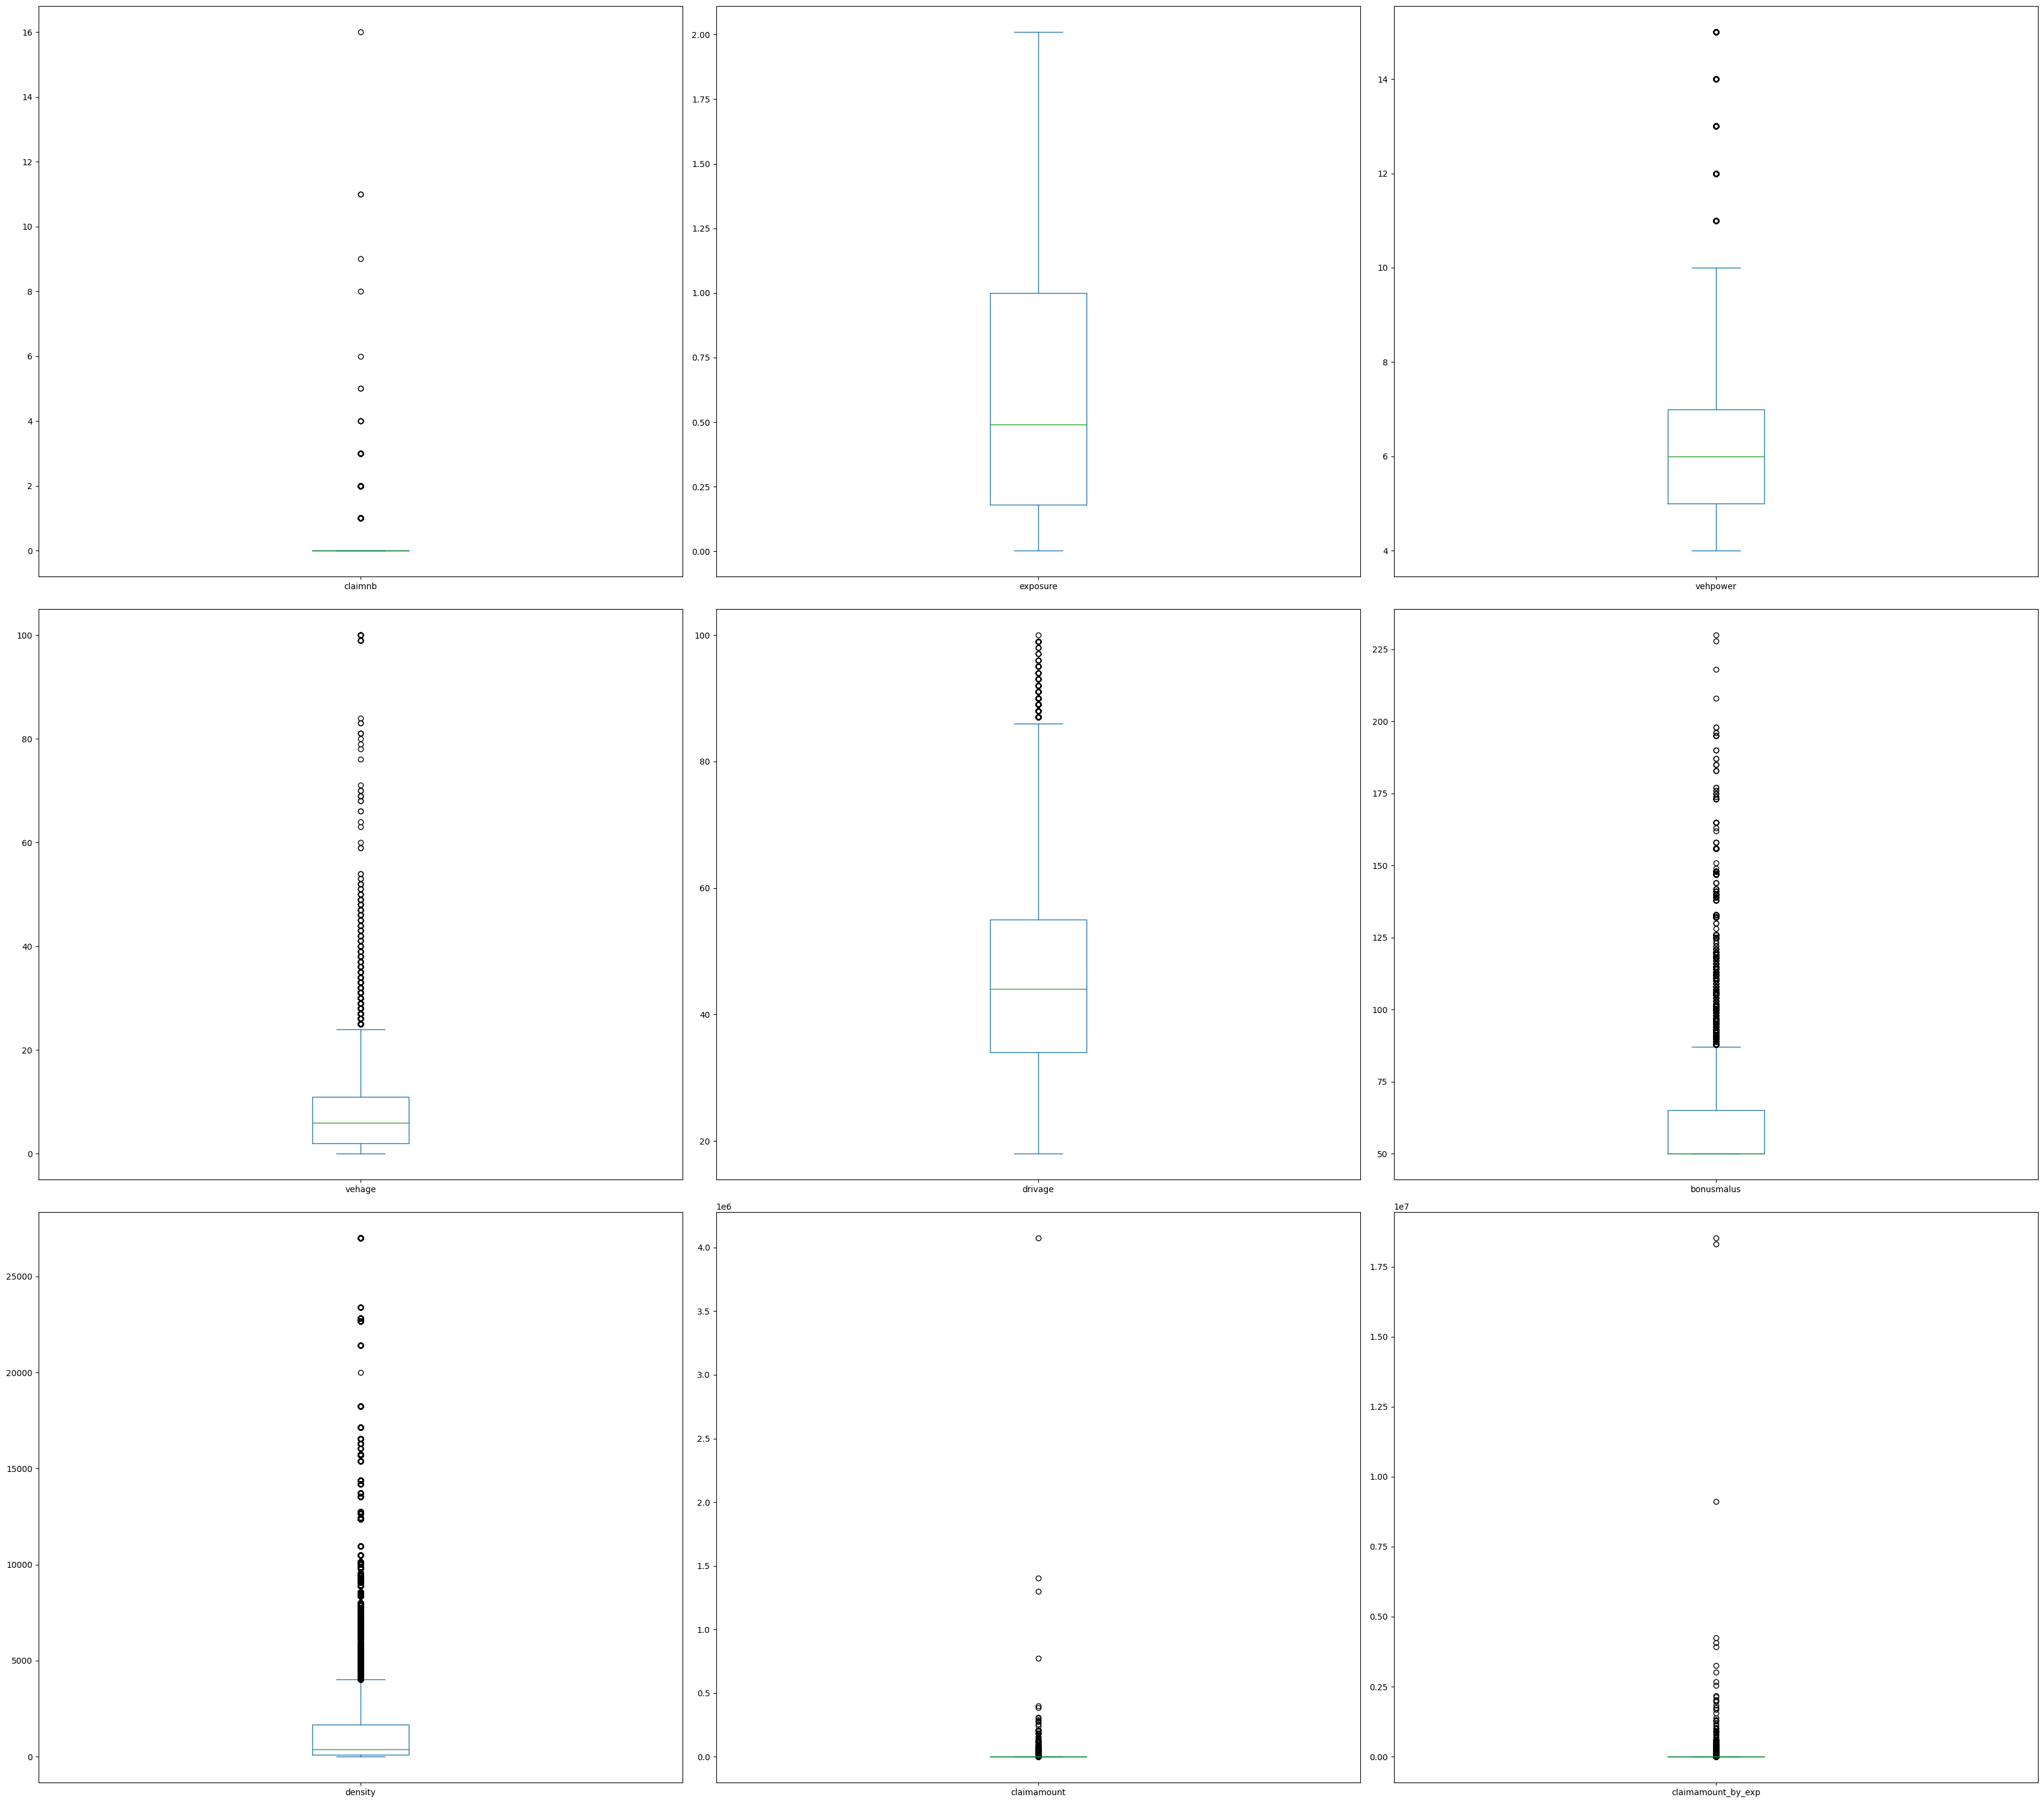

In [25]:
# Suche nach Ausreißern durch Barplots
num_features = ['claimnb', 'exposure', 'vehpower', 'vehage', 'drivage', 'bonusmalus', 'density', 'claimamount', 'claimamount_by_exp']
df_outliers = df[num_features].copy()

df_outliers.plot(kind='box', subplots=True, layout=(3,3), figsize=(34,30))
plt.tight_layout()
plt.show() 

### Beobachtung:
- claimnumber, claimamount und claimamount_by_exp sind extrem rechtsschief verteilt, insbesondere sind die meisten Zeilen 0 und Werte wenige sehr groß
- Fahrzeugalter, BonusMalus, Bevölkerungsdichte sind auch rechttschief verteilt
- Nach gesundem Menschenverstand zu urteilen, sind die Maximalwerte sinnvoll, d.h. unlogische Outlier wie z.B. drivage = 200 sind nicht vorhanden. Einzig der Maximalwert der Einwohnerdichte scheint sehr hoch zu sein. Laut Wikipedia hat Paris 20360 Einwohner pro km2, daher ist 27000 in manchen Stadtteilen denkbar.

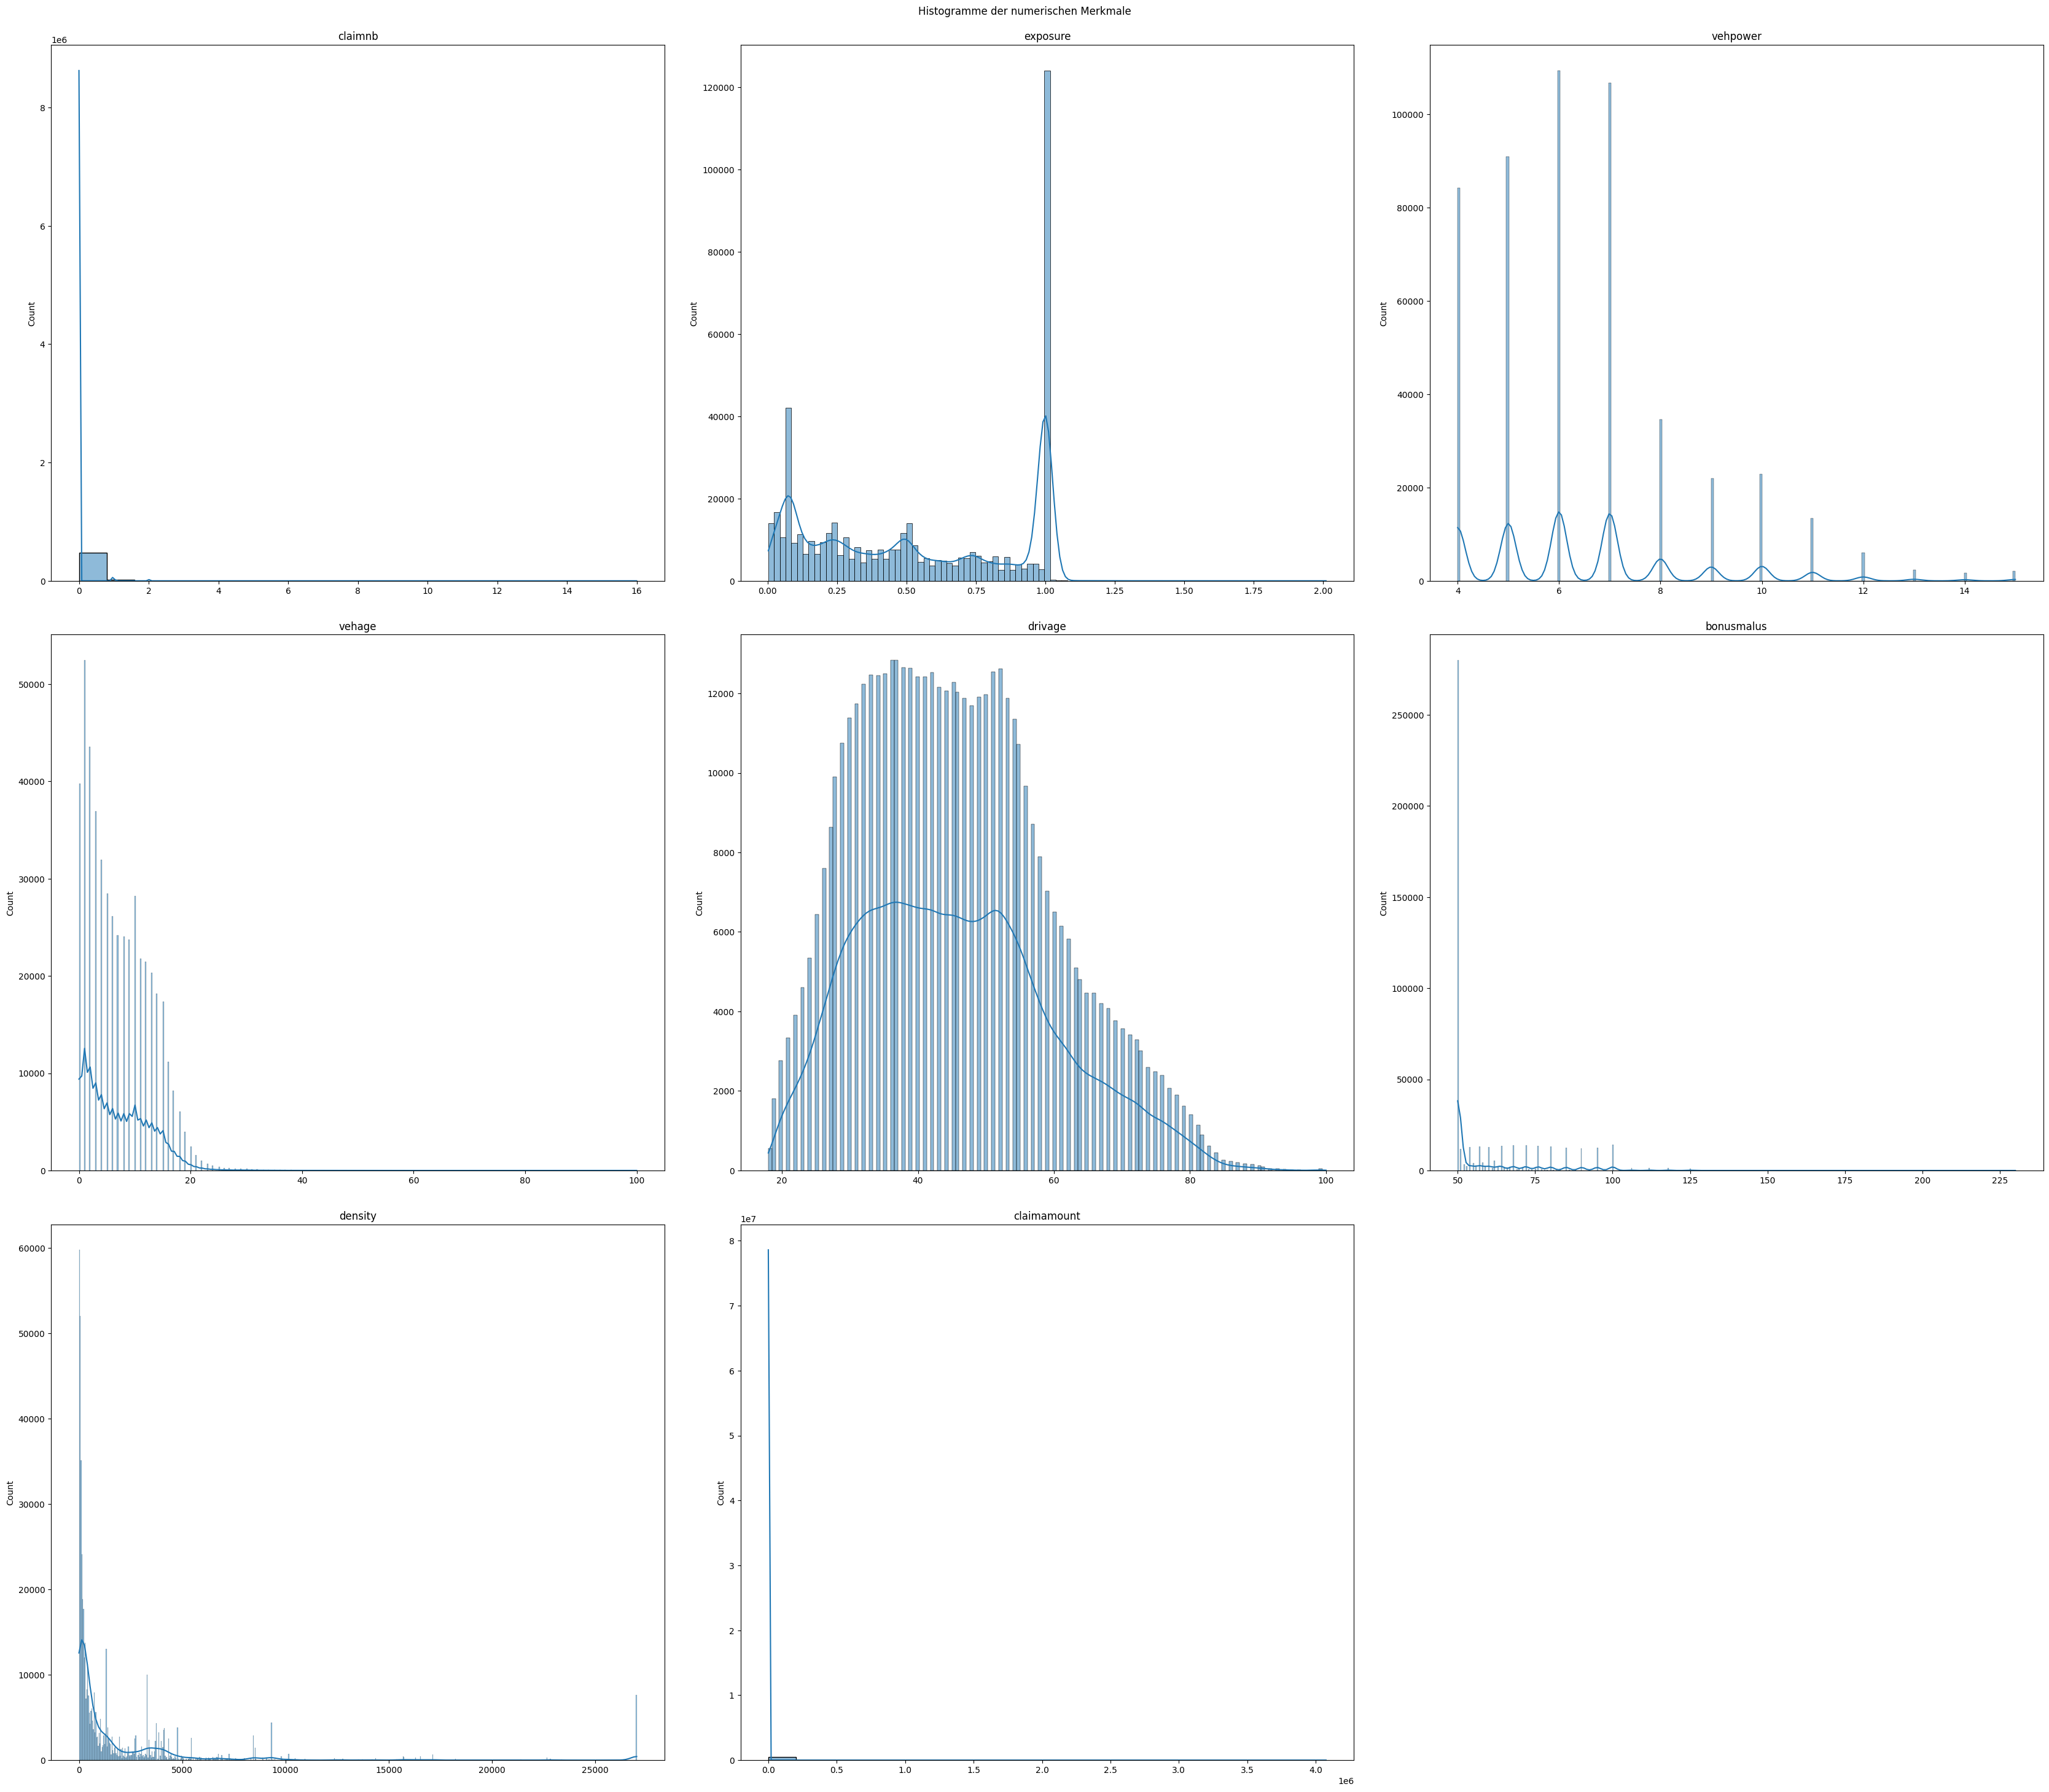

In [26]:
# Plotte die Histogramme
fig,ax = plt.subplots(3,3,figsize=(34,30))
count = 0
for idx, item in enumerate(num_features):
    sns.histplot(df[item],
                  kde=True, 
                  ax=ax[int(idx/3)][idx%3], 
                  ).set(title=item, xlabel='')
    count += 1
ax.flat[-1].set_visible(False) 
fig.suptitle("Histogramme der numerischen Merkmale")
fig.tight_layout(pad=3) 
plt.show()

#### Beobachtungen:
- Die Eindrücke der Boxplots werden bestätigt. 
- Auffallend ist, dass Exposure 2 peaks hat. D.h. evtl. wurde der Datensatz vorgefiltert oder manche Exposurezeiträume wurde gerundet. Bei einem natürlichen Bestand würde ich keine extrem Sprünge erwarten
- Bei der Nutzung von linearen Modellen, müssten die rechtsschiefen Variablen logarithmiert werden.

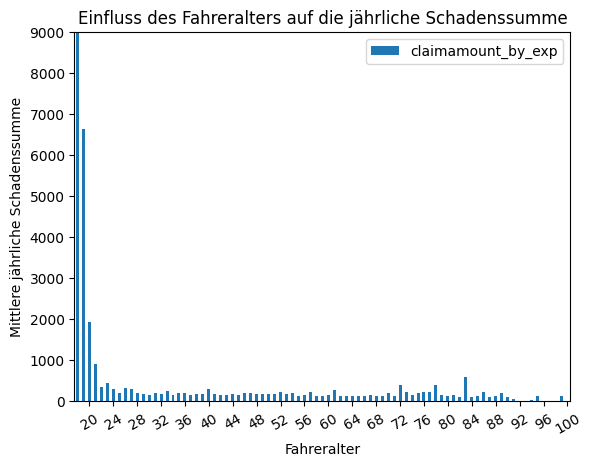

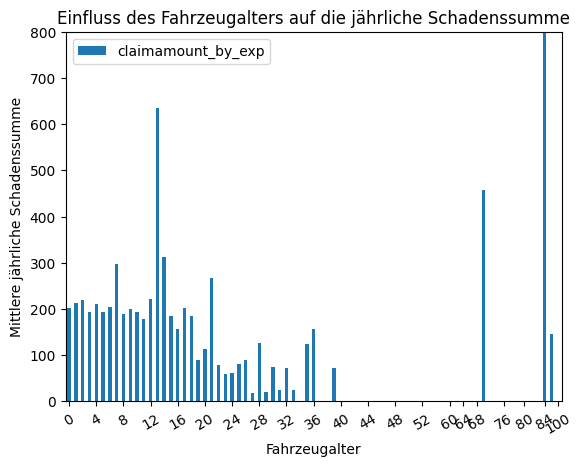

In [27]:
names = ["Fahreralter", "Fahrzeugalter"]
ylims = [9000,800]
startages = [18,0]
for col, name, ylim, startage in zip(["drivage", "vehage"], names, ylims, startages):
    df_plot_h = df.groupby(col)[["exposure","claimamount"]].sum()
    df_plot_h["claimamount_by_exp"] = df_plot_h.claimamount / df_plot_h.exposure
    df_plot_h.reset_index(inplace=True)
    df_plot_h.plot(kind="bar", x=col, y="claimamount_by_exp")
    plt.title(f"Einfluss des {name}s auf die jährliche Schadenssumme")
    plt.xlabel(name)
    plt.ylabel("Mittlere jährliche Schadenssumme")
    xticks_positions = [i for i, age in enumerate(df_plot_h[col]) if age % 4 == 0 and startage <= age <= 100]
    xticks_labels = [age for age in df_plot_h[col] if age % 4 == 0 and startage <= age <= 100]
    plt.ylim(0,ylim)
    plt.xticks(ticks=xticks_positions, labels=xticks_labels, rotation=30)
    plt.show()

#### Beobachtung:
- Das Fahreralter hat einen starken Einfluss auf die mittlere jährliche Schadenssumeme. Sehr große Werte werden bei sehr jungen Fahrern und Fahrerinnen beobachtet. Auch Menschen in hohen Alter haben eine erhöhte Schadenssumme.
- Einfluss des Fahrzeugalters wirkt gering. Tendenziell abnehmender jährlicher Schadensbetrag mit steigenden Alter. Einige Aureißer für sehr alte Fahrzeuge, aber dort ist die Anzahl der Verträge auch verschwindend gering. Daher sind diese Klassen anfällig für Ausreißer.
   - Bei mehr Zeit, wäre es sinnvoll den Ausschlag bei ca. 13 Jahre alten Fahrzeugen zu untersuchen.

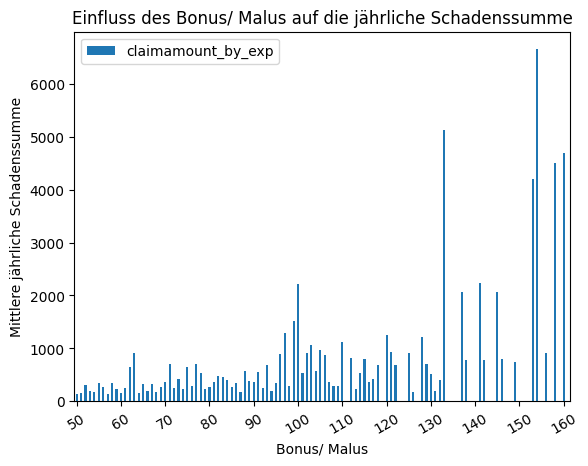

In [28]:
df_plot_h = df.groupby("bonusmalus")[["exposure","claimamount"]].sum()
df_plot_h["claimamount_by_exp"] = df_plot_h.claimamount / df_plot_h.exposure
df_plot_h.reset_index(inplace=True)
df_plot_h.plot(kind="bar", x="bonusmalus", y="claimamount_by_exp")
plt.title(f"Einfluss des Bonus/ Malus auf die jährliche Schadenssumme")
plt.xlabel("Bonus/ Malus")
plt.ylabel("Mittlere jährliche Schadenssumme")
xticks_positions = list(range(0,120,10)) 
xticks_labels = list(range(50,170,10))
plt.xticks(ticks=xticks_positions, labels=xticks_labels, rotation=30)
plt.show()

#### Beobachtung:
- Mit wachsenden bonusmalus steigt die jährliche Schadenssumme erheblich an

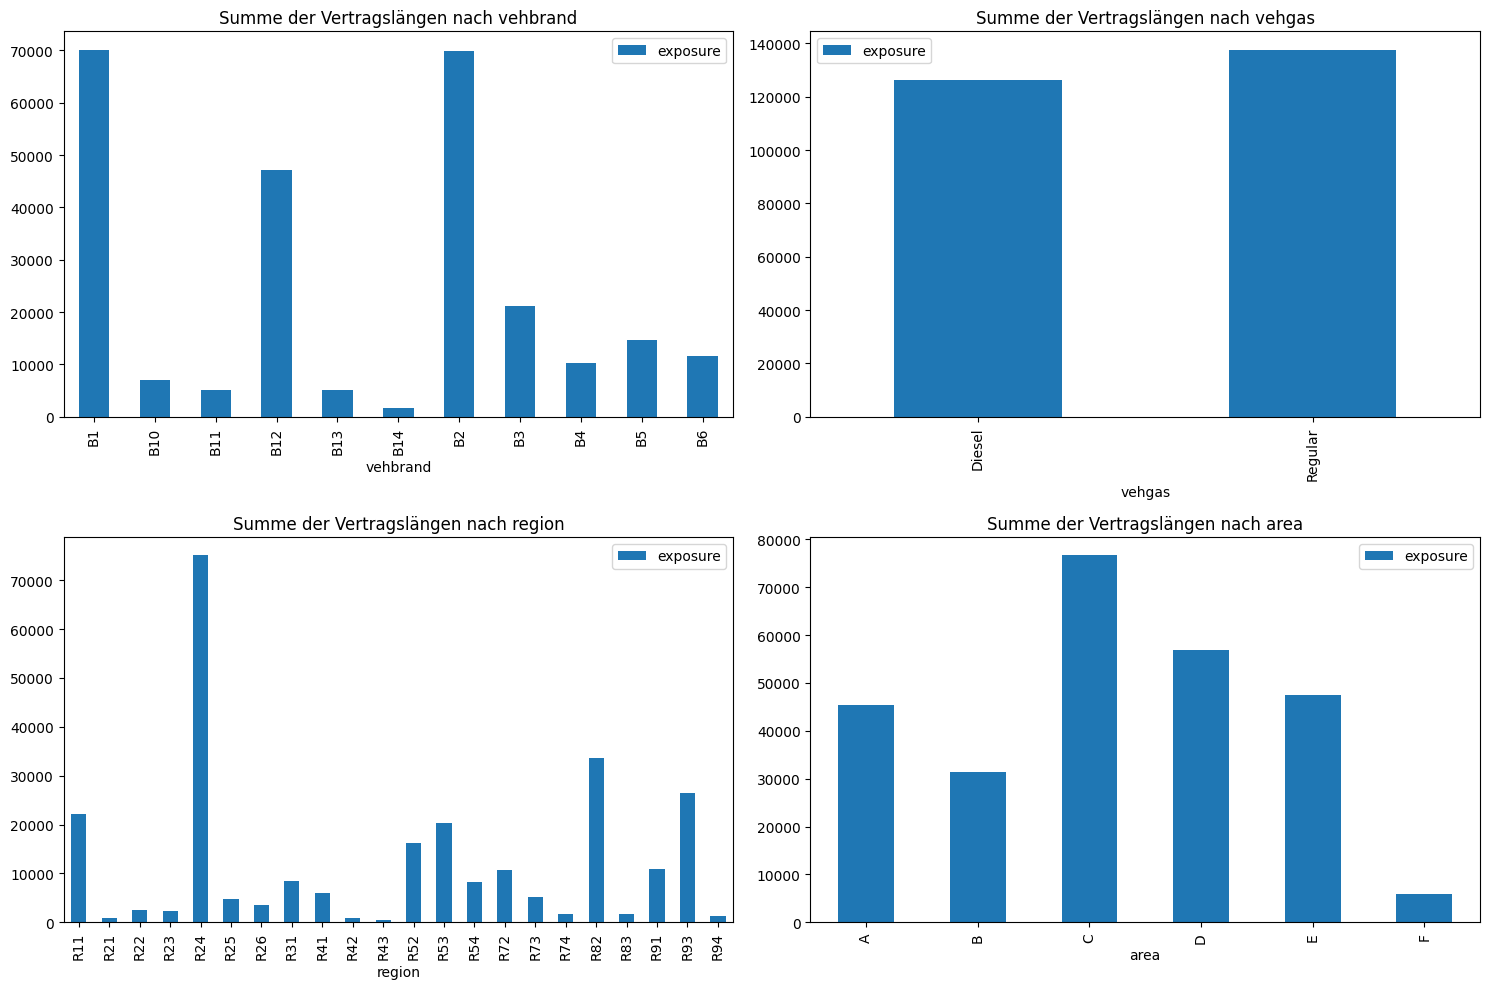

In [29]:

cat_features = ["vehbrand", "vehgas", "region","area"]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()


for idx,col in enumerate(cat_features):
    df_plot_h = df.groupby(col)[["exposure","claimamount"]].sum()
    df_plot_h.reset_index(inplace=True)
    df_plot_h.plot(kind="bar", x=col, y="exposure", ax=axes[idx])
    axes[idx].set_title(f"Summe der Vertragslängen nach {col}")
plt.tight_layout()
plt.show()

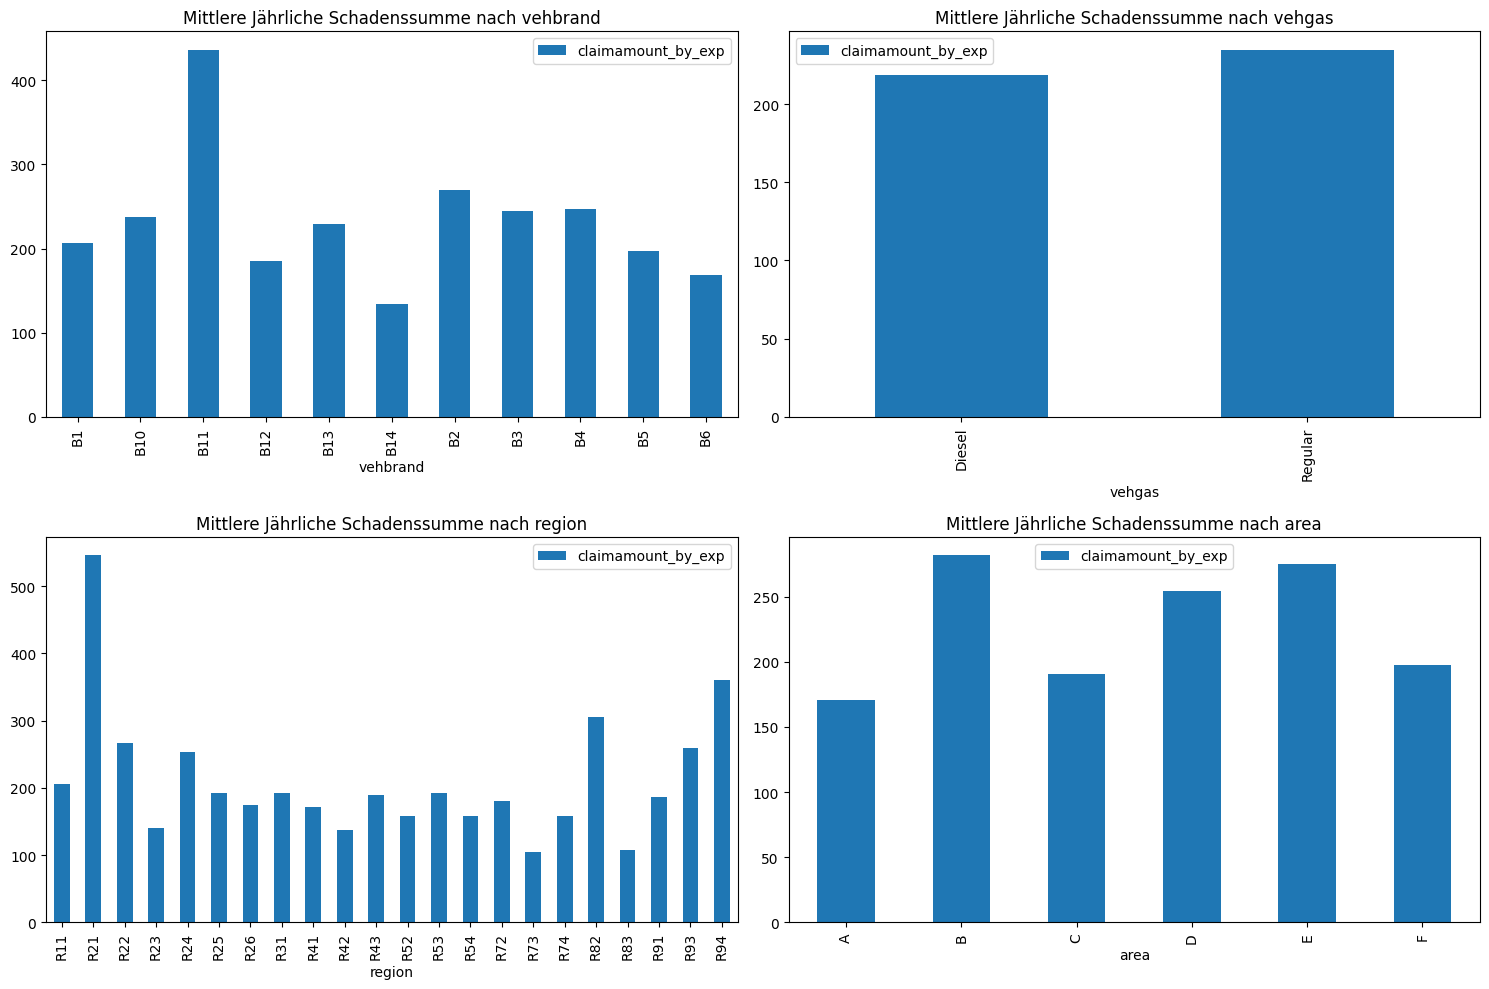

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()


for idx,col in enumerate(cat_features):
    df_plot_h = df.groupby(col)[["exposure","claimamount"]].sum()
    df_plot_h["claimamount_by_exp"] = df_plot_h.claimamount / df_plot_h.exposure
    df_plot_h.reset_index(inplace=True)
    df_plot_h.plot(kind="bar", x=col, y="claimamount_by_exp", ax=axes[idx])
    axes[idx].set_title(f"Mittlere Jährliche Schadenssumme nach {col}")
plt.tight_layout()
plt.show()

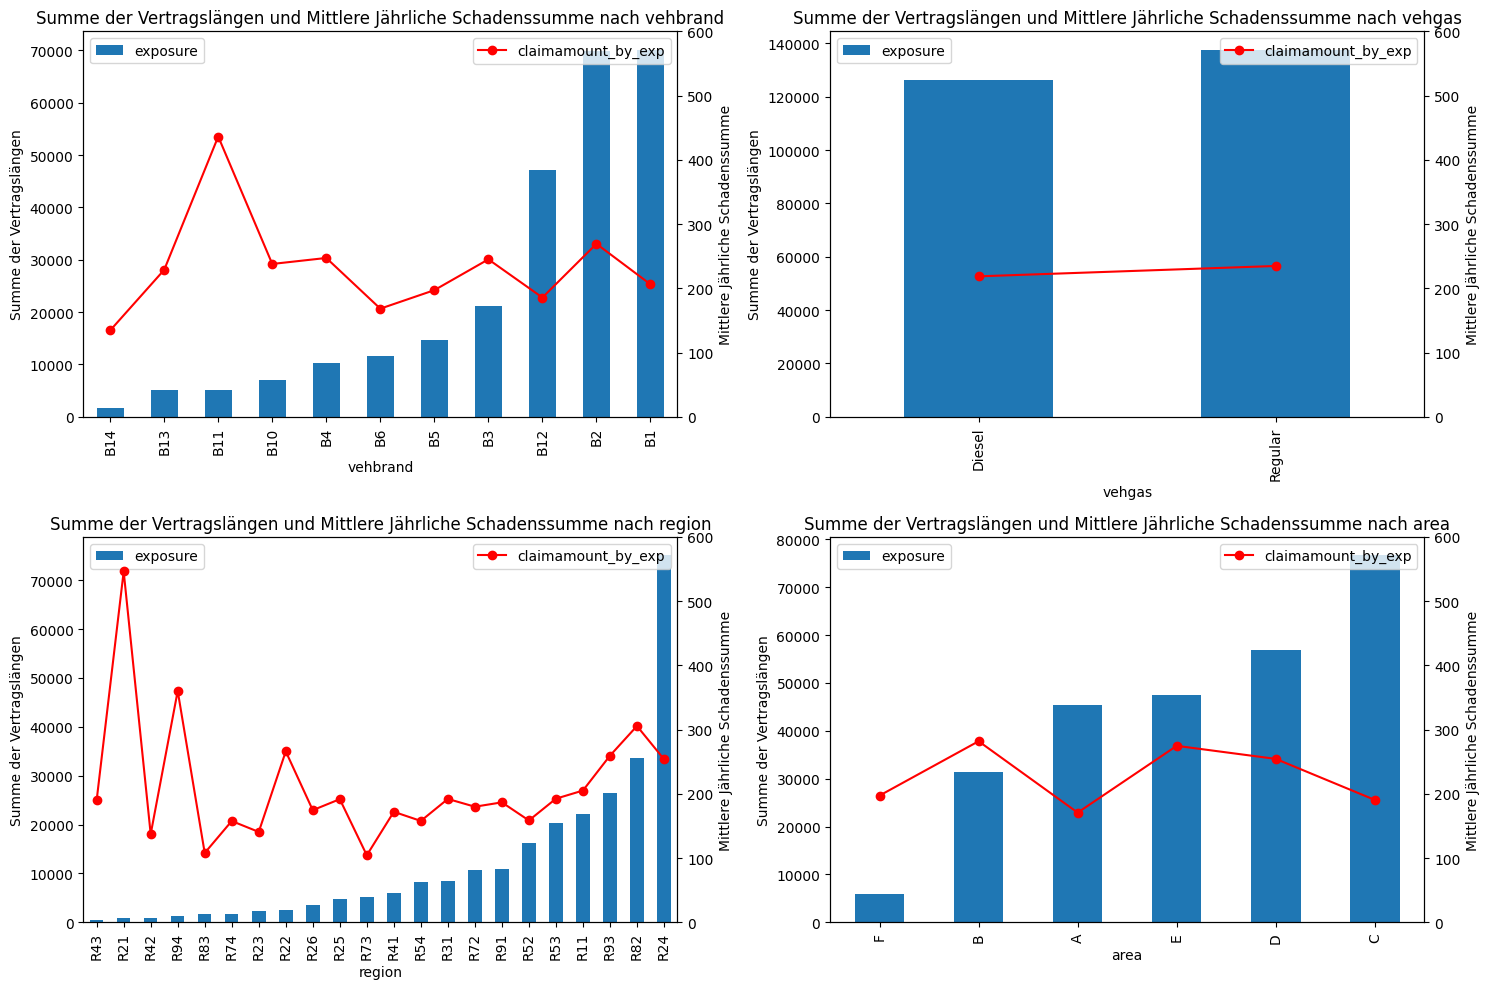

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(cat_features):
    ax1 = axes[idx]
    
    df_plot_h = df.groupby(col)[["exposure", "claimamount"]].sum()
    df_plot_h.reset_index(inplace=True)
    df_plot_h.sort_values("exposure", inplace=True)
    df_plot_h.plot(kind="bar", x=col, y="exposure", ax=ax1)
    
    ax1.set_title(f"Summe der Vertragslängen und Mittlere Jährliche Schadenssumme nach {col}")
    ax1.set_ylabel("Summe der Vertragslängen")
    
    ax2 = ax1.twinx()
    df_plot_h["claimamount_by_exp"] = df_plot_h.claimamount / df_plot_h.exposure
    df_plot_h.plot(kind="line", x=col, y="claimamount_by_exp", ax=ax2, color='red', marker='o')
    ax2.set_ylabel("Mittlere Jährliche Schadenssumme")
    ax2.set_ylim(0,600)
    
plt.tight_layout()
plt.show()

#### Beobachtung:
- Die Marke spielt eine untergeordnete Rolle. Nur B11 sticht heraus, das könnte aber auch Zufall sein und an der geringen Exposure liegen
- Es sind mehr Autos mit Benzin als mit Diesel versichert, die mittlere jährliche Schadenssummen unterscheiden sind nur geringfügig.
- Die Region und die Area haben einen Einfluss auf die mittlere jährliche Schadenssume. Area A und C fallen mit geringen mittleren jährlichen Schadenssummen auf. 

## Feature Engineering
- One hot encoding für die kategorialen Merkmale
- Falls lineare Modelle oder Modelle, die eine Distanz berechnen, genutzt werden sollen, dann müssen die Variablen vorher skaliert werden.
   - Ich fokussiere mich auf tree-based Modelle, da ist meines Wissens Skalierung der Variablen nicht nötig. 
- Entfernen von sehr stark korrelierten Features bei linearen Modellen, um Multikollinearität zu verhindern 
   - Tree-based Modelle können mit stark korrelierten Features besser umgehen

In [32]:
# Erzeuge one-hot Encoding für kategoriale Merkmale
df_encoded = pd.get_dummies(df, drop_first=True)
df_heatmap = df_encoded.drop(columns=["idpol", "exposure"]+ [col for col in df_encoded.columns if col.startswith("region")])

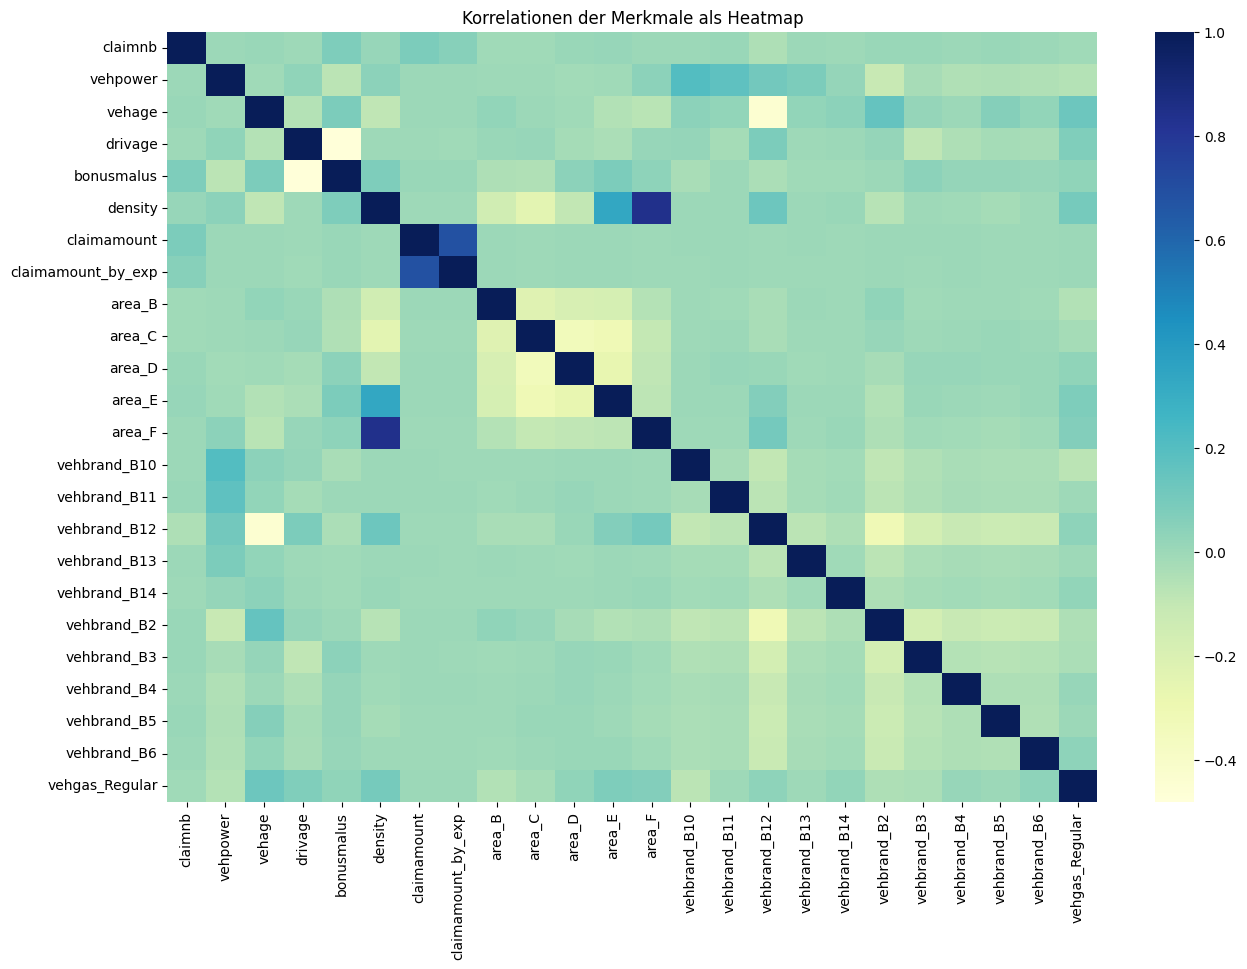

In [33]:
plt.figure(figsize=(15,10))
sns.heatmap(df_heatmap.corr(), cmap="YlGnBu")
plt.title("Korrelationen der Merkmale als Heatmap");

### Beobachtung:
- area_F ist stark korreliert mit density
   - bei linearen Modell würde ich area_F als Variable entfernen
- bonusmalus ist negativ mit driverage korreliert
- Zielvariable weist praktisch keine Korrelation auf, wie zu erwarten war

# Wahl des Modells
- Aufgrund der Zeitknappheit, hohen Performanz, Robustheit und Einfachheit der Handhabung (keine Interaktionsterme nötig, etc.): Tree-based models
- Metrik: RMSE (Root mean squared error)
   - der Schätzer, der den RMSE minimiert, ist erwartungstreu
   - Outlier werden härter bestraft im Vergleich zum MAE 
- Normales Vorgehen: Kreuzvalidierung der Modelle auf Trainingsdaten
   - Problem: Ich bin unsicher, wie ich sample_weights = exposure, in das Scoring und Training bei der cv einbringen kann.
   - Daher simplerer Ansatz: Weiterer Train-Test-Split auf den Trainingsdaten zur ersten Einschätzung der Modelle


In [34]:
# Generiere Trainings- und Testdaten
X = df_encoded.drop(columns=["idpol","claimnb","claimamount", "claimamount_by_exp"])
y = df_encoded.claimamount_by_exp

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Sub train-test split auf Trainingsdaten für Bewertung der Modelle
X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

exp_sub_train = X_sub_train.pop("exposure")
exp_sub_test = X_sub_test.pop("exposure")

exp_train = X_train.pop("exposure")
exp_test = X_test.pop("exposure")


In [35]:
def print_eval_metrics(y_true, y_pred, exposure):
    """ Schreibe die relevanten Metriken für ein Modell.
    """
    print("RMSE: ", sqrt(mean_squared_error(y_true, y_pred, sample_weight=exposure)))
    print("MAE: ", mean_absolute_error(y_true, y_pred, sample_weight=exposure)) 
    weighted_mean_error = np.sum(exposure * (y_true - y_pred)) / np.sum(exposure)
    print("WME (weighted mean error): ", weighted_mean_error,"\n") 


In [36]:
# Modell 1: Gradient Boosting
gbr = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, loss='squared_error', random_state=42, verbose=1)
gbr.fit(X_sub_train, y_sub_train, sample_weight=exp_sub_train)
y_pred_gbr = gbr.predict(X_sub_test)


      Iter       Train Loss   Remaining Time 
         1   569894936.9942           12.97s
         2   567100010.2552           12.59s
         3   564834470.8221           12.21s
         4   562998582.5123           12.58s
         5   561507953.3123           12.24s
         6   560300470.9966           12.04s
         7   559178958.8956           11.69s
         8   558246430.9740           11.36s
         9   557336113.9992           11.02s
        10   556567703.8738           10.69s
        20   551506332.6899            7.82s
        30   534350728.0430            5.21s
        40   532287486.8806            2.60s
        50   525232864.5755            0.00s


In [37]:
# Modell 2: Random Forest Regressor
rfr = RandomForestRegressor(n_estimators=20,max_depth=5,random_state=42,criterion="squared_error", n_jobs=-1)
rfr.fit(X_sub_train, y_sub_train, sample_weight=exp_sub_train)
y_pred_rfr = rfr.predict(X_sub_test)


In [38]:
# Modell 3: Decision Tree Regressor
dtr = DecisionTreeRegressor(max_depth=5, random_state=42)
dtr.fit(X_sub_train, y_sub_train, sample_weight=exp_sub_train)
y_pred_dtr = dtr.predict(X_sub_test)


In [39]:
print("Auswertung für GBR:")
print_eval_metrics(y_sub_test,y_pred_gbr, exp_sub_test)

print("Auswertung für RFR:")
print_eval_metrics(y_sub_test,y_pred_rfr, exp_sub_test)

print("Auswertung für DTR:")
print_eval_metrics(y_sub_test,y_pred_dtr, exp_sub_test)


Auswertung für GBR:
RMSE:  5399.749840943908
MAE:  450.5353595298857
WME (weighted mean error):  -24.41502975622224 

Auswertung für RFR:
RMSE:  6105.2931879649805
MAE:  418.1609447373437
WME (weighted mean error):  -28.59327503388474 

Auswertung für DTR:
RMSE:  6025.554677208628
MAE:  409.3644422784061
WME (weighted mean error):  -19.67958105711605 



### Beobachtung:
- Gradient Boosting Regressor hat den kleinsten RMSE, daher wird dieser final trainiert und angewandt
- Alle 3 Regressoren schätzen im Mittel die jährliche Schadenshöhe zu hoch


# Modellbuilding
- Normalerweise Hyperparametertuning mit Grid oder Randomsearch: Aus Zeitgründen verzichte ich auf diesen Schritt
- Anwendung GBR auf Train-Test Daten und Auswertung

In [40]:
# Training gbr für 
gbr = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, loss='squared_error', random_state=42, verbose=1)
gbr.fit(X_train, y_train, sample_weight=exp_train)
y_pred = gbr.predict(X_test)
y_pred_train = gbr.predict(X_train)

      Iter       Train Loss   Remaining Time 
         1   461169608.3270           16.23s
         2   459529870.2885           15.77s
         3   458199360.1749           15.20s
         4   457120289.9587           14.89s
         5   456245585.2790           14.54s
         6   455535030.9537           14.23s
         7   454928761.5735           13.91s
         8   454403259.4450           13.56s
         9   453901211.3284           13.26s
        10   453524323.0089           12.95s
        20   450620562.3329            9.77s
        30   444757438.7064            6.64s
        40   439137171.6870            3.34s
        50   434074992.5081            0.00s


In [41]:
print("Auswertung für GBR auf Testdaten:")
print_eval_metrics(y_test,y_pred, exp_test)

print("Auswertung für GBR auf Trainingsdaten:")
print_eval_metrics(y_train,y_pred_train, exp_train)

Auswertung für GBR auf Testdaten:
RMSE:  6062.0793826706185
MAE:  422.09342045415644
WME (weighted mean error):  -20.8087078187097 

Auswertung für GBR auf Trainingsdaten:
RMSE:  20834.466456046503
MAE:  451.7669948113188
WME (weighted mean error):  -1.8915043161233273e-13 



### Interpretation:
- Es gibt einen großen Unterschied zwischen den Metriken auf den Testdaten und den Trainingsdaten
   - Ein Indikator für Overfitting
   - Die Zielvariable ist sehr unbalanced, daher kann es sein, dass sich die Verteilungen in Trainings und Testdaten stark unterscheiden, was die Modellbeurteilung erschwert
- Der WME = -21 für die Testdaten bedeutet, dass im Schnitt der jährliche Verbrauch 21 Geldeinheiten zu hoch geschätzt wird. 
- Weitere Auswertung sinnvoll: Visuell überprüfen, ob die Verteilung einzelner Merkmale korrekt vom Modell abgebildet wird auf Trainings- und Testdaten.

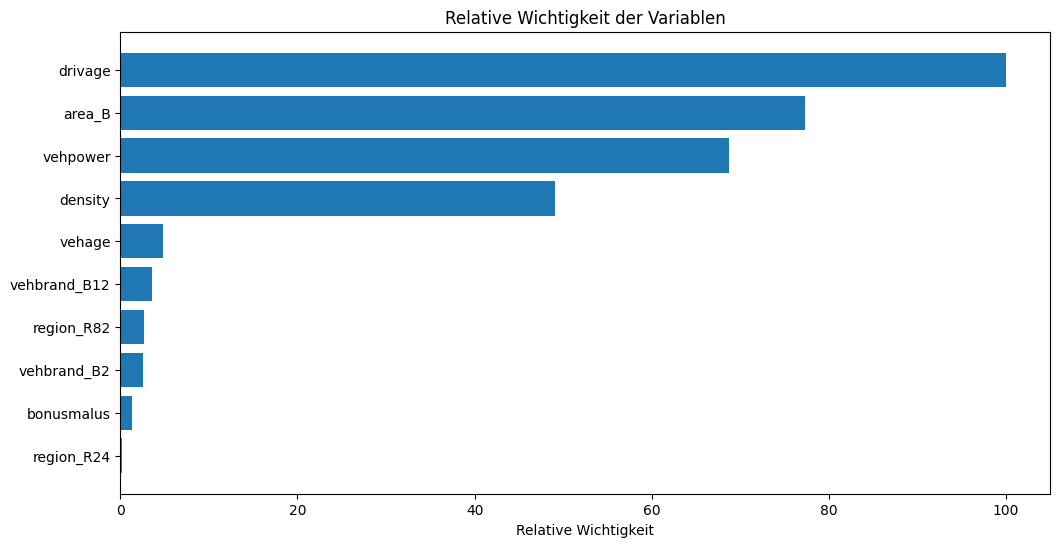

In [42]:
# Plotte die Wichtigkeit der Features

feature_importance = gbr.feature_importances_
df_feature_importance = pd.DataFrame({
    "feature": X_train.columns,
    "rel_importance": (feature_importance/feature_importance.max())*100
})
df_feature_importance.sort_values(by="rel_importance", ascending=True, inplace=True)


plt.figure(figsize=(12, 6))
plt.barh(df_feature_importance['feature'].tail(10),
         df_feature_importance['rel_importance'].tail(10),
         align='center')
plt.xlabel('Relative Wichtigkeit')
plt.title('Relative Wichtigkeit der Variablen')
plt.show()

#### Interpretation:
- Das Fahreralter, Area = "B", Fahrzeugstärke, Dichte im Wohngebiet sind die wichtigsten Einflussfaktoren 


# Verbesserungen im Modell

- Überprüfen, ob der train-test-split ähnliche Verteilungen für train und test liefert. Wenn nicht, dann muss die Methodik verbessert werden. 
- Hyperparametertuning und Kreuzvalidierung einführen
- Saubere EDA mit den Wechselwirkungen zwischen je 2 Merkmalen nachreichen
- Entfernen von unwichtigen Features

### Etwas weitergedacht
- Im Endeffekt vermischt das jetzige Modell den Prozess der Unfallhäufigkeit und der Schadensschätzung pro Unfall
- Idealerweise beide Prozesse separat modellieren, dann lassen sich auch die Metriken bessen interpretieren. 
   - Gütemaß für Schätzung Poissonprozess
   - Gütemaß für zu erwartender Schaden pro Unfall
